In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid', palette='hls')

In [2]:
embeddings = pd.read_csv('./Embeddings.csv', index_col=0)
embeddings = embeddings.sample(frac = 1)

embeddings.head(5)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,Labels
4910,0.025376,-0.235563,2.944172,0.910850,0.570571,-0.001908,0.823311,-0.949495,-0.547465,-1.736381,...,0.378243,-1.611390,0.907460,-0.538404,-2.154041,-0.596277,1.266570,-0.245648,-0.843052,1
118,0.209757,0.158517,1.889034,-0.740048,1.517548,-1.213201,0.598562,-0.022771,0.167630,-1.598761,...,0.788203,-0.943086,0.550772,0.283251,-1.079770,-0.464965,0.899662,-0.071080,-1.149808,1
3136,-0.074548,0.682131,-1.346843,-1.147058,3.671100,2.265628,-0.708633,1.271551,1.686038,-0.219556,...,2.617552,-0.363975,2.396271,-1.310379,-2.352231,1.942179,1.452920,-1.712955,-1.085513,0
327,0.501287,-1.049664,1.646765,-0.016294,-1.690846,-0.004198,0.934575,0.821594,0.856516,-2.176182,...,0.121457,-0.237637,-0.032860,-0.351098,0.547574,-1.600628,-0.477851,0.823775,-0.992719,0
4374,-1.013319,-0.435589,-0.198382,-0.114287,2.407366,-1.260314,0.186404,-0.478735,0.341897,0.187920,...,1.241113,1.340117,-0.045777,-0.088008,-0.878643,0.934846,2.033346,0.017166,-1.199893,1


In [3]:
X = embeddings.iloc[:,:-1]
y = embeddings.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Text(0.5, 1.0, 'Prueba')

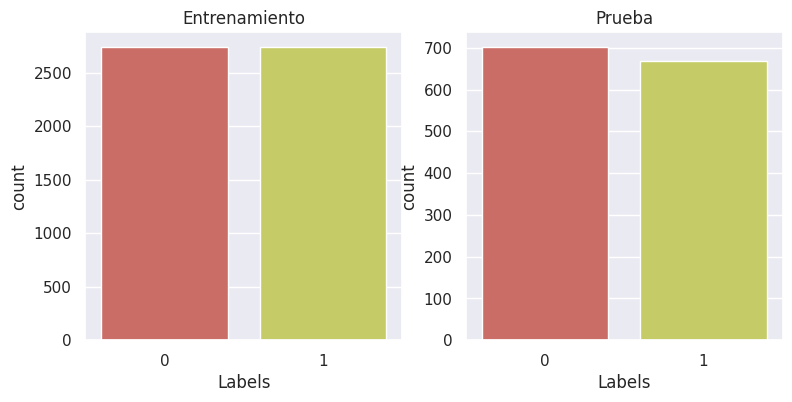

In [4]:
# Crea una matriz de subplots de 2x2
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 4))

# Subplot 1
sns.countplot(x=y_train, ax=axs[0])
axs[0].set_title("Entrenamiento")

# Subplot 2
sns.countplot(x=y_test, ax=axs[1])
axs[1].set_title("Prueba")

In [5]:
import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import OrderedDict
import seaborn as sns
import pandas as pd

In [6]:
X_train = torch.tensor(X_train.values).float()
y_train = torch.tensor(y_train.values).float()

X_test = torch.tensor(X_test.values).float()
y_test = torch.tensor(y_test.values).float()

# Crear un conjunto de datos de tensores utilizando TensorDataset
dataset_train = TensorDataset(X_train, y_train)

batch = 50
# Crear un objeto DataLoader
trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)

Accuracy: 0.5197080291970803


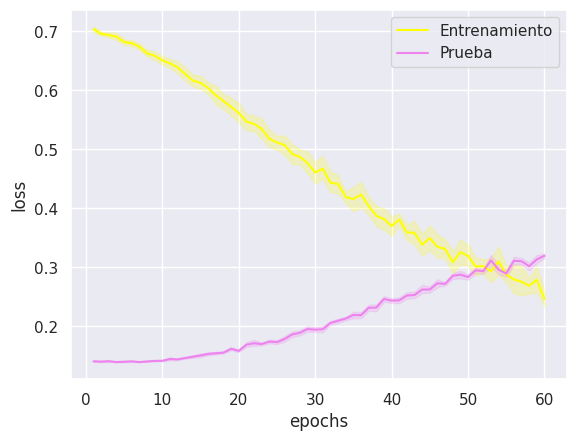

In [80]:
# Hyperparameters for our network
input_size = 96
hidden_sizes = [64, 32, 16]
output_size = 1

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                    ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                    ('relu1', nn.ReLU()),
                    ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                    ('relu2', nn.ReLU()),
                    ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                    ('relu3', nn.Sigmoid()),
                    ('fc4', nn.Linear(hidden_sizes[2], output_size)),
                    ('sigmoid', nn.Sigmoid())
                    ]))

def predict(model,criterion):
        o = model.forward(X_test)
        # Calculate loss
        l = criterion(o, torch.unsqueeze(y_test, 1))
        return l.item()

def acurracy(model):
        pred = model.forward(X_test).detach().numpy().reshape(-1,)
        tarjet = np.array(y_test)
        pred = np.array([ 0 if p<=0.5 else 1 for p in pred ])
        corrects = 0 
        for a,b in zip(pred, tarjet):
             if a == b: 
                   corrects+= 1 
        return corrects / int(tarjet.shape[0])

# Entrenamiento por epocas

# Definition of loss, learning rate & epochs
learning_rate = 0.8

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

epochs = 60
print_every = int((X_train.shape[0]/batch) / 20)
steps = 0 
list_loss = []
list_epochs = []

loss_test = []
epochs_test = []

# Comenzando entrenamiento. . . 
for e in range(epochs):
    running_loss = 0
    running_loss_test = 0
    # En cada epoca cargamos todos los batches 
    for inputs, labels in iter(trainloader):
        steps += 1
        # Aplanar los labels para formato [50,1]
        labels = torch.unsqueeze(labels, 1)
        # Reiniciar los gradientes
        optimizer.zero_grad()
        # Forward pass
        outputs = model.forward(inputs)
        # Calculate loss
        loss = criterion(outputs, labels)
        # Calculate loss for test
        running_loss_test = predict(model,criterion)
        # Backprogation
        loss.backward()
        # Actualiza los pesos de acuerdo a un paso del optimizador
        optimizer.step()
        # Guardamos la perdida para control del entrenamiento
        running_loss += loss.item()
        # imprimimos cada 20% lotes
        if steps % print_every == 0:
            list_loss.append(running_loss/print_every)
            list_epochs.append(e+1)
            running_loss = 0

            loss_test.append(running_loss_test/print_every)
            epochs_test.append(e+1)
            running_loss_test = 0 
        
df = pd.DataFrame()
df['epochs'] = list_epochs
df['loss'] = list_loss
df['epochs_test'] = epochs_test
df['loss_test'] = loss_test

sns.set_theme(style="darkgrid")

sns.lineplot(x="epochs", y="loss", data=df, color='yellow', label='Entrenamiento')
sns.lineplot(x="epochs_test", y="loss_test", data=df, color='violet', label='Prueba')

print('Accuracy: ' +str(acurracy(model)))